In [1]:
# Import packages
import json

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

In [2]:
# Import self-defined functions
from scraping_parsing import get_imdb_soundtrack, parse_track_entry_clean               # imdb scraping by movie id, parsing
from spotify_utils import get_artist_genres                                             # from parsed artists get their genres through spotify api
from mood_arc import get_average_mood, normalize_features_by_movie, resample_mood_arc   # feature engineering for each soundtrack, normalization, interpolation 

## Data Parsing and Merging

In [3]:
df_movie = pd.read_csv('Movie List.csv')

In [4]:
df_movie.head()

,Movie Title,Year,Vibe Keywords,IMDb ID
0,SLC Punk,1998,"rebellious nostalgia, punk decay, emotional chaos",tt0133189
1,SubUrbia (Linklater),1996,"aimlessness, Gen X burnout, parking lot dread",tt0120238
2,Suburbia (Penelope Spheeris),1983,"raw punk squat teens, emotional vacuum",tt0086589
3,Smithereens,1982,"NYC no wave desperation, scene-girl collapse",tt0084698
4,Ghost World,2001,"post-high school alienation, ironic distance",tt0162346


In [5]:
soundtrack_list = get_imdb_soundtrack("tt0095853")
for i, line in enumerate(soundtrack_list):
    print(f"{i+1}. {line}")

1. Baby the TransWritten, Performed & Produced byJoe StrummerJoe Strummer performs courtesy of CBS Records United Kingdom Limited
2. Nothin' 'Bout Nothin'Written, Performed & Produced byJoe StrummerJoe Strummer performs courtesy of CBS Records United Kingdom Limited
3. Trash CityWritten, Performed & Produced byJoe StrummerJoe Strummer performs courtesy of CBS Records United Kingdom Limited
4. Nefertiti RockWritten, Performed & Produced byJoe StrummerJoe Strummer performs courtesy of CBS Records United Kingdom Limited
5. Cholo VestWritten, Performed & Produced byJoe StrummerJoe Strummer performs courtesy of CBS Records United Kingdom Limited
6. Something HappenedWritten & Performed byLou ReedProduced byLou Reed&Arthur Baker
7. H.M.S. Pinafore ExcerptsWritten byW.S. Gilbert&Arthur Sullivan
8. She's on My MindWritten by John HusseyPerformed & Produced byLittle AmericaLittle America performs courtesy of Geffen Records
9. Waiting on LoveWritten byKurt Neumann&Sammy Llanas(as Sam Llanas)Perf

In [6]:
all_data = []

# Iterate by rows and call get_imdb_soundtrack to scrape from imdb
for _, row in df_movie.iterrows():
    title = row['Movie Title']  
    imdb_id = row['IMDb ID']
    
    print(f"Scraping {title} ({imdb_id})")
    raw_lines = get_imdb_soundtrack(imdb_id)

    for line in raw_lines:
        all_data.append({
            "movie": title,
            "imdb_id": imdb_id,
            "raw_track": line
        })

Scraping SLC Punk (tt0133189)
Scraping SubUrbia (Linklater) (tt0120238)
Scraping Suburbia (Penelope Spheeris) (tt0086589)
Scraping Smithereens (tt0084698)
Scraping Ghost World (tt0162346)
Scraping Out of the Blue (tt0081291)
Scraping Ladies and Gentlemen, The Fabulous Stains (tt0082639)
Scraping Times Square (tt0081635)
Scraping River’s Edge (tt0091860)
Scraping Permanent Record (tt0095853)
Scraping Gummo (tt0119237)
Scraping Kids (tt0113540)
Scraping The Doom Generation (tt0112887)
Scraping My Own Private Idaho (tt0102494)
Scraping We Are the Best! (tt2364975)
Scraping Mid90s (tt5613484)
Scraping Paranoid Park (Gus Van Sant) (tt0842929)
Scraping Wild Tigers I Have Known (tt0430768)
Scraping Slacker (tt0102943)
Scraping Nowhere (tt0119809)


In [8]:
# Store raw scraping records in df_soundtracks
df_soundtracks = pd.DataFrame(all_data)

In [9]:
df_soundtracks.head(10)

,movie,imdb_id,raw_track
0,SLC Punk,tt0133189,"High AdventureCourtesy of NLR, Inc.Published b..."
1,SLC Punk,tt0133189,Sex & ViolencePerformed byThe Exploited(as Exp...
2,SLC Punk,tt0133189,Too HotPerformed byThe SpecialsWritten byPrinc...
3,SLC Punk,tt0133189,Mirror in the BathroomPerformed by FifiWritten...
4,SLC Punk,tt0133189,Champaign BreakfastPerformed & Written byJohn ...
5,SLC Punk,tt0133189,Little OceanPerformed & Written byWhiskey Bisc...
6,SLC Punk,tt0133189,1969Performed byThe StoogesWritten byDavid Ale...
7,SLC Punk,tt0133189,Pooh BarePerformed by Holistic OliveWritten by...
8,SLC Punk,tt0133189,I Love Livin' in the CityPerformed byFearWritt...
9,SLC Punk,tt0133189,No More BullshitPerformed byCamper Van Beethov...


In [ ]:
parsed_rows = []

# Iterate by rows and call parse_track_entry_clean to parse and extract track, artist, and remixer from raw track data
for _, row in df_soundtracks.iterrows():
    parsed = parse_track_entry_clean(row['raw_track'])
    parsed['movie'] = row['movie']
    parsed['imdb_id'] = row['imdb_id']
    parsed_rows.append(parsed)

df_parsed = pd.DataFrame(parsed_rows)

In [11]:
df_parsed.head(10)

,track,artist,remixer,movie,imdb_id
0,High Adventure,None,None,SLC Punk,tt0133189
1,Sex & Violence,The Exploited(as Exploited),None,SLC Punk,tt0133189
2,Too Hot,The Specials,None,SLC Punk,tt0133189
3,Mirror in the Bathroom,Fifi,None,SLC Punk,tt0133189
4,Champaign Breakfast,John Sbarra,None,SLC Punk,tt0133189
5,Little Ocean,Whiskey Biscuit,None,SLC Punk,tt0133189
6,1969,The Stooges,None,SLC Punk,tt0133189
7,Pooh Bare,Holistic Olive,None,SLC Punk,tt0133189
8,I Love Livin' in the City,Fear,None,SLC Punk,tt0133189
9,No More Bullshit,Camper Van Beethoven,None,SLC Punk,tt0133189


In [12]:
df_parsed.groupby('movie').size()

movie
Ghost World                                  36
Gummo                                        21
Kids                                         22
Ladies and Gentlemen, The Fabulous Stains    13
Mid90s                                       25
My Own Private Idaho                         16
Nowhere                                      39
Out of the Blue                              10
Paranoid Park (Gus Van Sant)                 20
Permanent Record                             16
River’s Edge                                 11
SLC Punk                                     42
Slacker                                      24
Smithereens                                  11
SubUrbia (Linklater)                         20
Suburbia (Penelope Spheeris)                  6
The Doom Generation                          26
Times Square                                 20
We Are the Best!                             20
Wild Tigers I Have Known                     16
dtype: int64

In [13]:
df_parsed.to_csv('soundtrack_parsed.csv', index=False, encoding='utf-8')

## Spotify APIs & Get Genres

In [32]:
df_parsed = pd.read_csv('soundtrack_parsed.csv')

In [ ]:
# Use your own Spotify client_id and client_secret
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(
    client_id=client_id,
    client_secret=client_secret
))

In [34]:
# Example of searching genres by artist via Spotify APIs and function
genres = get_artist_genres(sp, "Talking Heads")
print(genres)

['new wave', 'post-punk']


In [35]:
# Call function to get genres and then map back to the dataframe
artist_names = df_parsed['artist'].dropna().unique() # get the unique artist list
artist_genre_map = {}

remixer_names = df_parsed['remixer'].dropna().unique()
remixer_genre_map = {}

for name in artist_names:
    artist_genre_map[name] = get_artist_genres(sp, name)

for name in remixer_names:
    remixer_genre_map[name] = get_artist_genres(sp, name)

# Create a new dataframe for merging genres onto tracks
df_merged = df_parsed.copy()

df_merged['genres_a'] = df_merged['artist'].map(artist_genre_map)
df_merged['genres_r'] = df_merged['remixer'].map(remixer_genre_map)

In [36]:
# Extract and create a column for primary genre
df_merged['primary_genre'] = df_merged['genres_a'].apply(
    lambda g: g[0] if isinstance(g, list) and len(g) > 0 else None
)

df_merged.head()

,track,artist,remixer,movie,imdb_id,genres_a,genres_r,primary_genre
0,High Adventure,NaN,NaN,SLC Punk,tt0133189,NaN,NaN,None
1,Sex & Violence,The Exploited(as Exploited),NaN,SLC Punk,tt0133189,[],NaN,None
2,Too Hot,The Specials,NaN,SLC Punk,tt0133189,"[ska, rocksteady, ska punk]",NaN,ska
3,Mirror in the Bathroom,Fifi,NaN,SLC Punk,tt0133189,[],NaN,None
4,Champaign Breakfast,John Sbarra,NaN,SLC Punk,tt0133189,"[ragtime, exotica]",NaN,ragtime


In [37]:
df_merged.tail()

,track,artist,remixer,movie,imdb_id,genres_a,genres_r,primary_genre
409,Freak Out,311,NaN,Nowhere,tt0119809,"[reggae rock, funk rock, rap rock]",NaN,reggae rock
410,Land Beyond The Sun,Flying Saucer Attack,NaN,Nowhere,tt0119809,"[shoegaze, space rock, post-rock, dream pop, d...",NaN,shoegaze
411,Generation Wrekkked (Danny Saber Remix),Chuck D,Danny Saber,Nowhere,tt0119809,"[east coast hip hop, old school hip hop]","[big beat, trip hop]",east coast hip hop
412,Dose (The Critter Mix),Filter,Critter,Nowhere,tt0119809,"[industrial rock, post-grunge, industrial meta...",[],industrial rock
413,Love Is Stronger Than Death,The The,NaN,Nowhere,tt0119809,[],NaN,None


In [38]:
# All genre list
# Ensure only lists are processed

# Ensure NaNs are replaced with empty lists
df_merged['genres_a'] = df_merged['genres_a'].apply(lambda x: x if isinstance(x, list) else [])
df_merged['genres_r'] = df_merged['genres_r'].apply(lambda x: x if isinstance(x, list) else [])

# Combine genres from both artist and remixer
combined_genres = df_merged.apply(
    lambda row: row['genres_a'] + row['genres_r'],
    axis=1
)

# Flatten and extract unique genres
unique_genres = sorted(set(genre for sublist in combined_genres for genre in sublist))

len(unique_genres)



183

In [26]:
unique_genres

['3 step',
 'acid house',
 'acid jazz',
 'acid rock',
 'adult standards',
 'african gospel',
 'alt country',
 'alternative dance',
 'alternative metal',
 'alternative rock',
 'ambient',
 'ambient folk',
 'americana',
 'anti-folk',
 'aor',
 'art rock',
 'avant-garde',
 'bebop',
 'big beat',
 'bisrock',
 'black metal',
 'bluegrass',
 'blues',
 'blues rock',
 'boogie-woogie',
 'boom bap',
 'breakbeat',
 'britpop',
 'calypso',
 'celtic',
 'celtic punk',
 'celtic rock',
 'chamber music',
 'christmas',
 'classic blues',
 'classic country',
 'classic rock',
 'classical',
 'cold wave',
 'cool jazz',
 'country',
 'country blues',
 'country rock',
 'crunk',
 'dark ambient',
 'darkwave',
 'death metal',
 'deathrock',
 'deep house',
 'disco',
 'doo-wop',
 'downtempo',
 'dream pop',
 'drone',
 'drone metal',
 'dub',
 'east coast hip hop',
 'ebm',
 'egg punk',
 'electro',
 'electronic',
 'electronica',
 'emo',
 'enka',
 'exotica',
 'experimental',
 'folk metal',
 'folk punk',
 'folk rock',
 'free ja

In [12]:
df_merged.to_csv('soundtrack_genres.csv', index=False, encoding='utf-8')

## EDA

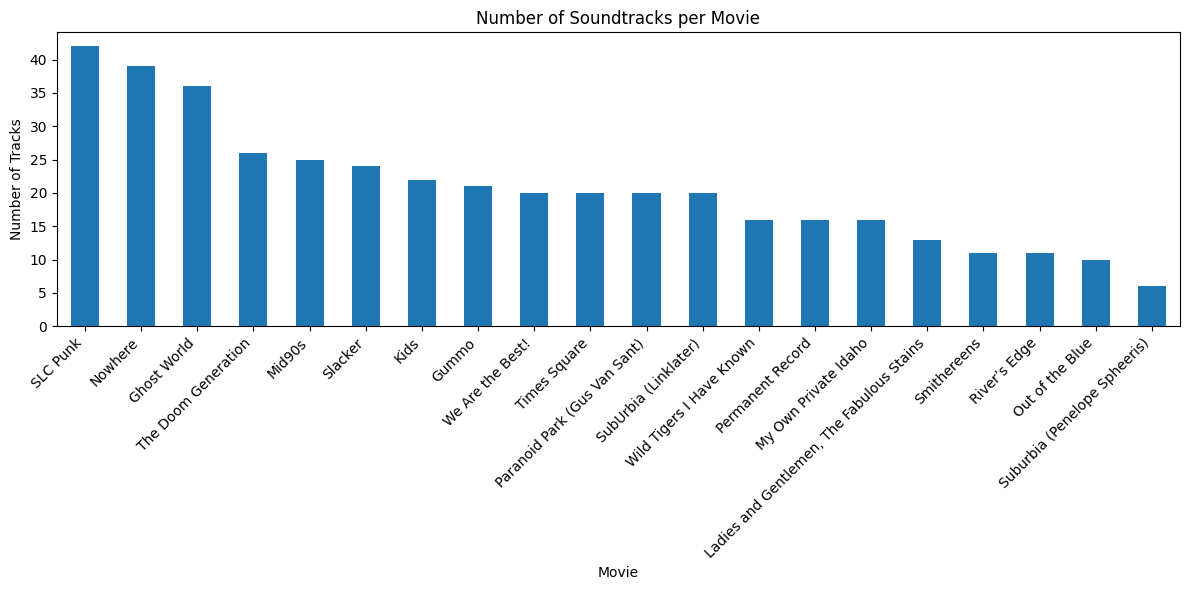

In [ ]:
# Count number of soundtracks per movie
soundtrack_counts = df_merged.groupby('movie').size().sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 6))
soundtrack_counts.plot(kind='bar')

plt.title("Number of Soundtracks per Movie")
plt.xlabel("Movie")
plt.ylabel("Number of Tracks")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


<Axes: ylabel='primary_genre'>

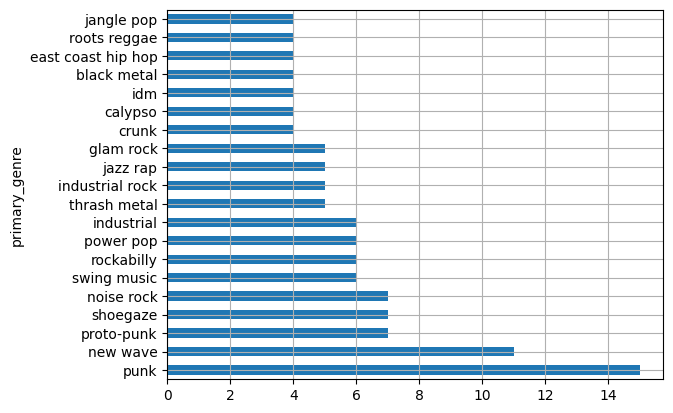

In [ ]:
df_genres_exploded = df_merged.explode('primary_genre')

df_genres_exploded['primary_genre'].value_counts().head(20).plot(kind='barh')

df_merged['genre_count'] = df_merged['primary_genre'].apply(lambda x: len(x) if isinstance(x, list) else 0)
df_merged['genre_count'].hist(bins=range(1, 10))


<Axes: ylabel='genres'>

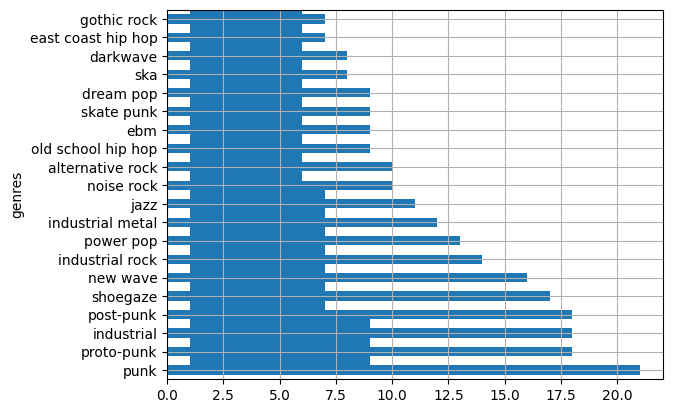

In [ ]:
df_genres_exploded = df_merged.explode('genres')

df_genres_exploded['genres'].value_counts().head(20).plot(kind='barh')

df_merged['genre_count'] = df_merged['genres'].apply(lambda x: len(x) if isinstance(x, list) else 0)
df_merged['genre_count'].hist(bins=range(1, 10))

In [ ]:
df_exploded = df_merged.explode('genres')

In [38]:
genre_counts = (
    df_exploded.groupby(['movie', 'genres'])
    .size()
    .reset_index(name='count')
)


In [39]:
top_genres_per_movie = (
    genre_counts
    .sort_values(['movie', 'count'], ascending=[True, False])
    .groupby('movie')
    .head(3)
)

top_genres_per_movie

,movie,genres,count
14,Ghost World,jazz,4
32,Ghost World,swing music,4
4,Ghost World,calypso,3
33,Gummo,black metal,4
37,Gummo,dark ambient,3
46,Gummo,metalcore,2
63,Kids,east coast hip hop,3
75,Kids,old school hip hop,3
58,Kids,bebop,2
79,"Ladies and Gentlemen, The Fabulous Stains",power pop,3


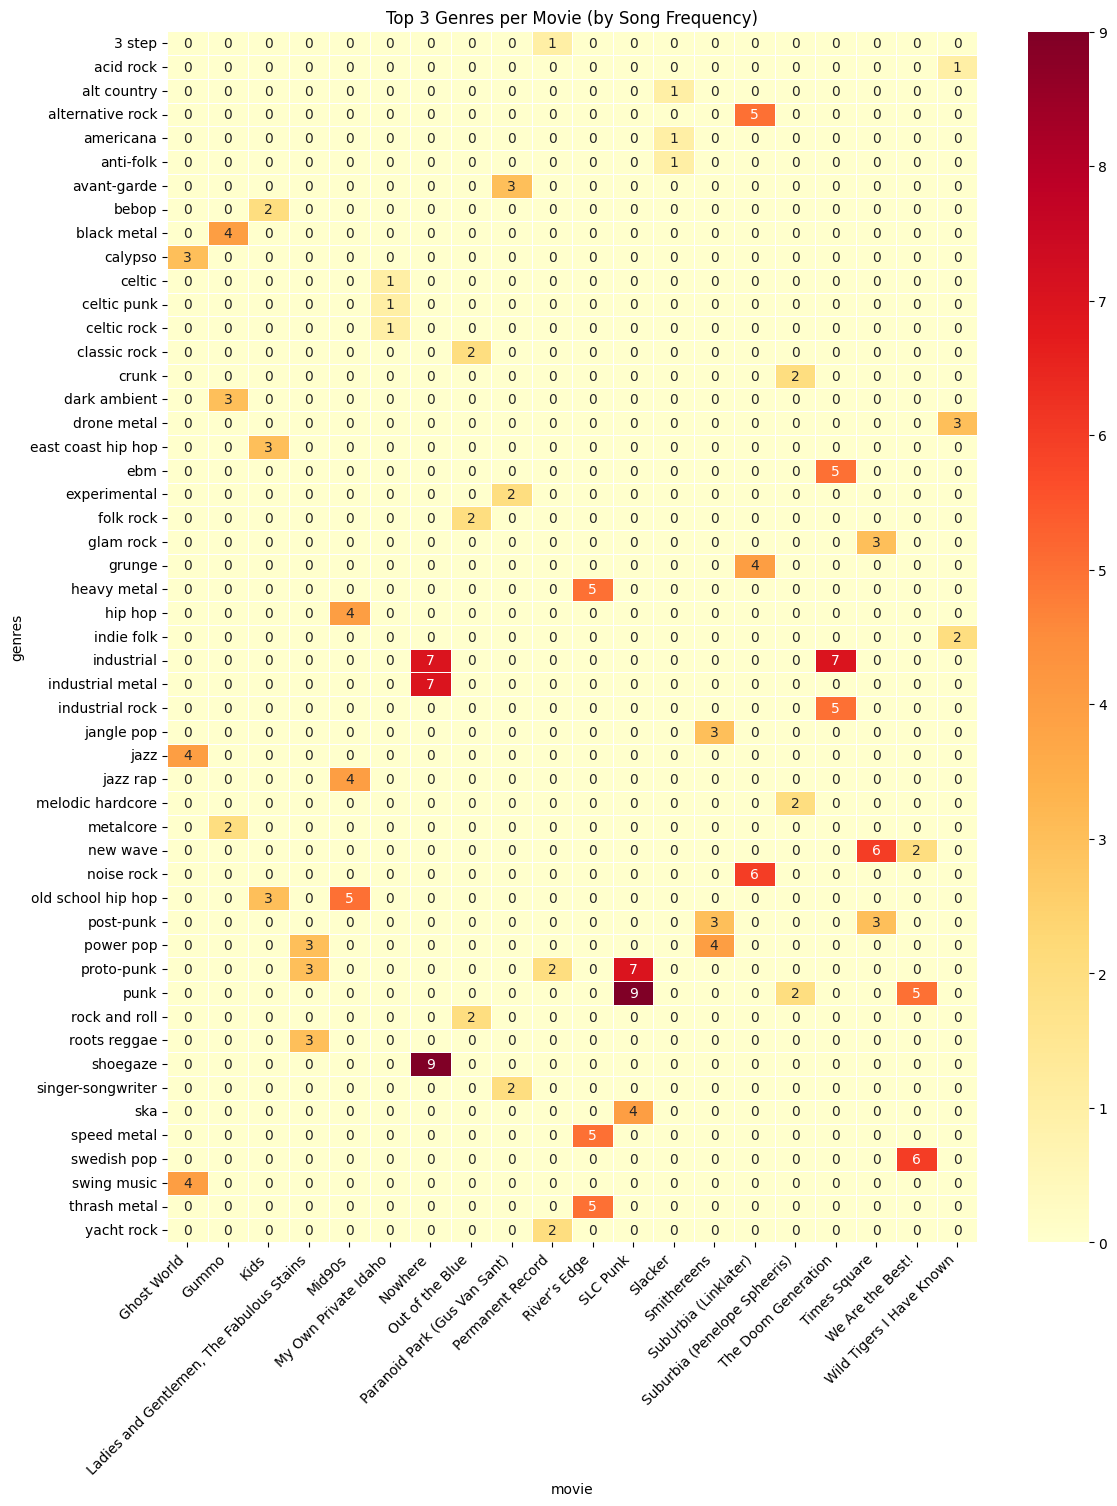

In [42]:
heatmap_data = (
    top_genres_per_movie
    .pivot(index='genres', columns='movie', values='count')
    .fillna(0)
)

plt.figure(figsize=(12, 15))
sns.heatmap(heatmap_data, cmap='YlOrRd', linewidths=0.5, annot=True, fmt=".0f")

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.title("Top 3 Genres per Movie (by Song Frequency)")
plt.show()


## Audio Features Engineering

In [28]:
# Load pre-curated genre mood map
with open("final_genre_mood_map.json", "r", encoding="utf-8") as f:
    genre_mood_map = json.load(f)

In [30]:
df_merged = pd.read_csv('soundtrack_genres.csv')

In [39]:
df_merged.head()

,track,artist,remixer,movie,imdb_id,genres_a,genres_r,primary_genre
0,High Adventure,NaN,NaN,SLC Punk,tt0133189,[],[],None
1,Sex & Violence,The Exploited(as Exploited),NaN,SLC Punk,tt0133189,[],[],None
2,Too Hot,The Specials,NaN,SLC Punk,tt0133189,"[ska, rocksteady, ska punk]",[],ska
3,Mirror in the Bathroom,Fifi,NaN,SLC Punk,tt0133189,[],[],None
4,Champaign Breakfast,John Sbarra,NaN,SLC Punk,tt0133189,"[ragtime, exotica]",[],ragtime


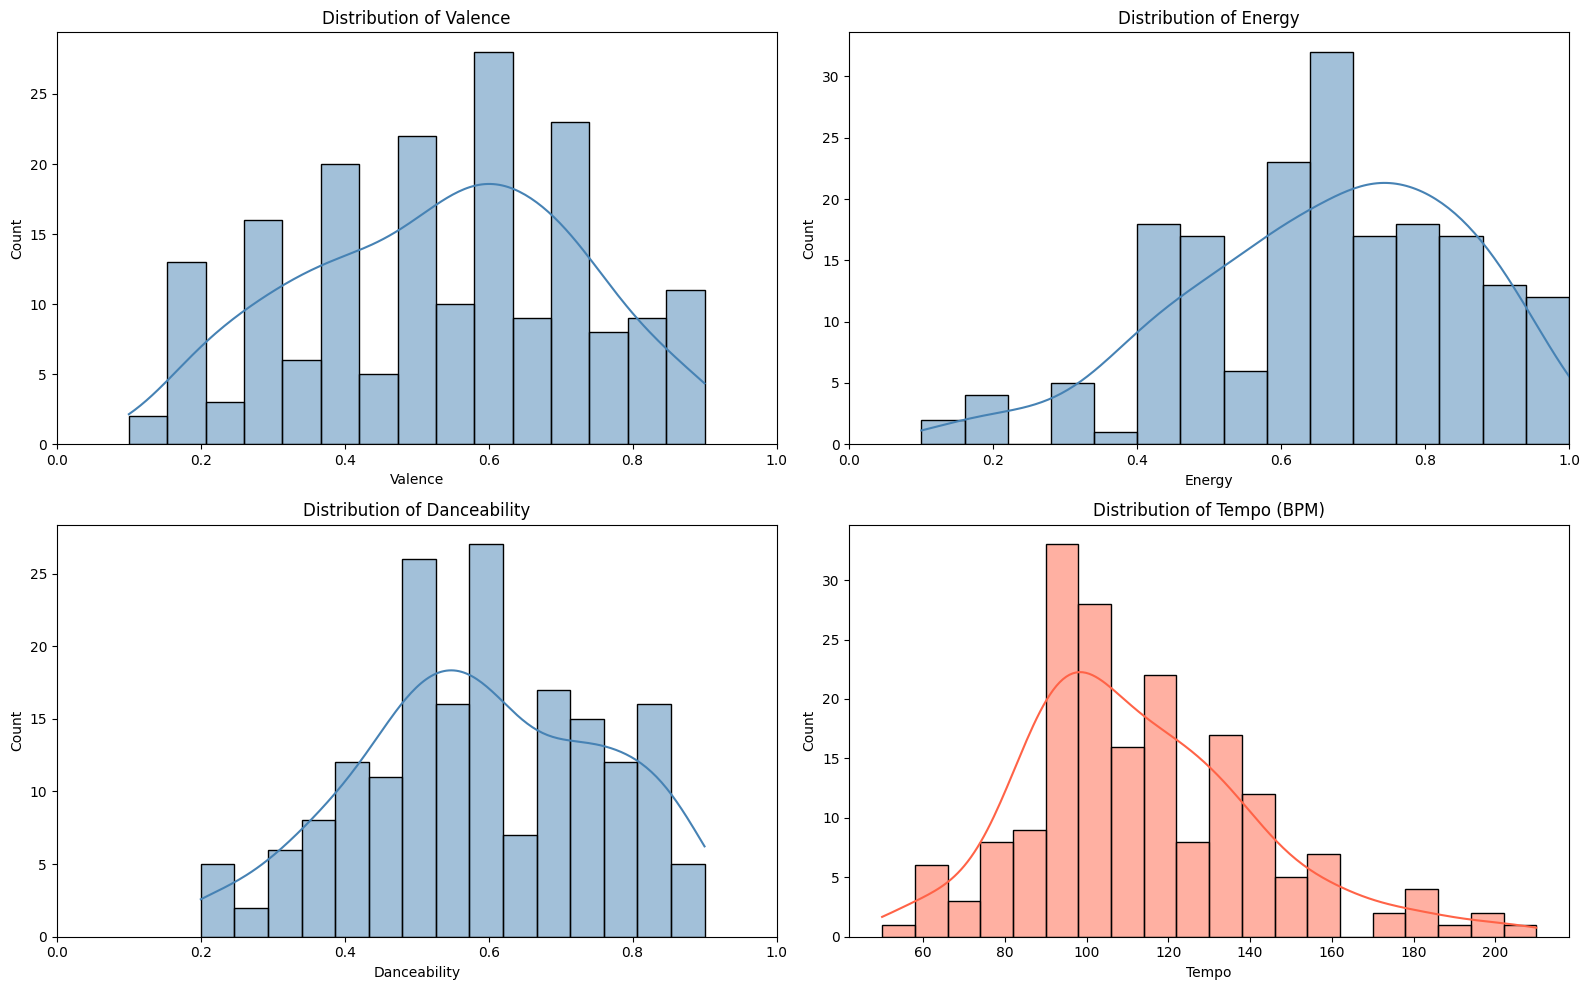

In [40]:
# Feature distribution of all the genres used

# Convert to DataFrame
df_genre = pd.DataFrame.from_dict(genre_mood_map, orient='index')

# Define the features to plot
low_scale_features = ['valence', 'energy', 'danceability']
high_scale_feature = 'tempo'

plt.figure(figsize=(16, 10))

# Plot valence, energy, danceability
for i, feature in enumerate(low_scale_features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df_genre[feature], bins=15, kde=True, color='steelblue')
    plt.title(f'Distribution of {feature.capitalize()}')
    plt.xlabel(feature.capitalize())
    plt.ylabel('Count')
    plt.xlim(0, 1)  # Normalize range

# Plot tempo separately
plt.subplot(2, 2, 4)
sns.histplot(df_genre[high_scale_feature], bins=20, kde=True, color='tomato')
plt.title('Distribution of Tempo (BPM)')
plt.xlabel('Tempo')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


In [41]:
df_genre

,valence,energy,danceability,tempo
african gospel,0.90,0.70,0.60,110
alternative rock,0.50,0.70,0.55,130
aor,0.60,0.60,0.50,120
art rock,0.40,0.50,0.40,110
big band,0.80,0.70,0.70,140
...,...,...,...,...
psychedelic rock,0.50,0.60,0.45,102
soul,0.70,0.60,0.70,95
space music,0.30,0.20,0.20,60
stoner metal,0.25,0.85,0.40,92


In [42]:
# Check if there are missing genres
missing_genres = [g for g in unique_genres if g not in genre_mood_map]

# Print results
if not missing_genres:
    print("All genres have corresponding mood features.")
else:
    print(f"Missing mood features for {len(missing_genres)} genres:")
    print(missing_genres)


All genres have corresponding mood features.


In [43]:
# Apply the mood feature extraction
mood_df = df_merged[['genres_a', 'genres_r']].apply(
    lambda row: get_average_mood(genre_mood_map, row['genres_a'], row['genres_r']),
    axis=1
).apply(pd.Series)

# Merge mood features back into the main DataFrame
df_withfeatures = pd.concat([df_merged, mood_df], axis=1)

# Preview the result
df_withfeatures[['movie', 'track', 'artist', 'genres_a', 'genres_r', 'valence', 'energy', 'danceability', 'tempo']].head()


,movie,track,artist,genres_a,genres_r,valence,energy,danceability,tempo
0,SLC Punk,High Adventure,NaN,[],[],NaN,NaN,NaN,NaN
1,SLC Punk,Sex & Violence,The Exploited(as Exploited),[],[],NaN,NaN,NaN,NaN
2,SLC Punk,Too Hot,The Specials,"[ska, rocksteady, ska punk]",[],0.666667,0.716667,0.766667,133.333333
3,SLC Punk,Mirror in the Bathroom,Fifi,[],[],NaN,NaN,NaN,NaN
4,SLC Punk,Champaign Breakfast,John Sbarra,"[ragtime, exotica]",[],0.725000,0.450000,0.650000,100.000000


In [44]:
df_withfeatures.head()

,track,artist,remixer,movie,imdb_id,genres_a,genres_r,primary_genre,valence,energy,danceability,tempo
0,High Adventure,NaN,NaN,SLC Punk,tt0133189,[],[],None,NaN,NaN,NaN,NaN
1,Sex & Violence,The Exploited(as Exploited),NaN,SLC Punk,tt0133189,[],[],None,NaN,NaN,NaN,NaN
2,Too Hot,The Specials,NaN,SLC Punk,tt0133189,"[ska, rocksteady, ska punk]",[],ska,0.666667,0.716667,0.766667,133.333333
3,Mirror in the Bathroom,Fifi,NaN,SLC Punk,tt0133189,[],[],None,NaN,NaN,NaN,NaN
4,Champaign Breakfast,John Sbarra,NaN,SLC Punk,tt0133189,"[ragtime, exotica]",[],ragtime,0.725000,0.450000,0.650000,100.000000


In [45]:
df_withfeatures[['movie', 'track', 'artist', 'genres_a', 'genres_r', 'valence', 'energy', 'danceability', 'tempo']].tail()

,movie,track,artist,genres_a,genres_r,valence,energy,danceability,tempo
409,Nowhere,Freak Out,311,"[reggae rock, funk rock, rap rock]",[],0.633333,0.750000,0.700000,105.00
410,Nowhere,Land Beyond The Sun,Flying Saucer Attack,"[shoegaze, space rock, post-rock, dream pop, d...",[],0.385714,0.407143,0.407143,85.00
411,Nowhere,Generation Wrekkked (Danny Saber Remix),Chuck D,"[east coast hip hop, old school hip hop]","[big beat, trip hop]",0.550000,0.675000,0.712500,98.75
412,Nowhere,Dose (The Critter Mix),Filter,"[industrial rock, post-grunge, industrial meta...",[],0.362500,0.862500,0.537500,121.25
413,Nowhere,Love Is Stronger Than Death,The The,[],[],NaN,NaN,NaN,NaN


In [46]:
complete_counts = df_withfeatures.groupby('movie')[['valence', 'energy', 'danceability', 'tempo']].apply(
    lambda df: (~df.isna()).any(axis=1).sum()
)

print(complete_counts)


movie
Ghost World                                  18
Gummo                                        12
Kids                                         10
Ladies and Gentlemen, The Fabulous Stains     7
Mid90s                                       17
My Own Private Idaho                          3
Nowhere                                      30
Out of the Blue                               5
Paranoid Park (Gus Van Sant)                  5
Permanent Record                              6
River’s Edge                                 10
SLC Punk                                     24
Slacker                                       6
Smithereens                                   6
SubUrbia (Linklater)                         15
Suburbia (Penelope Spheeris)                  4
The Doom Generation                          18
Times Square                                 14
We Are the Best!                              8
Wild Tigers I Have Known                      5
dtype: int64


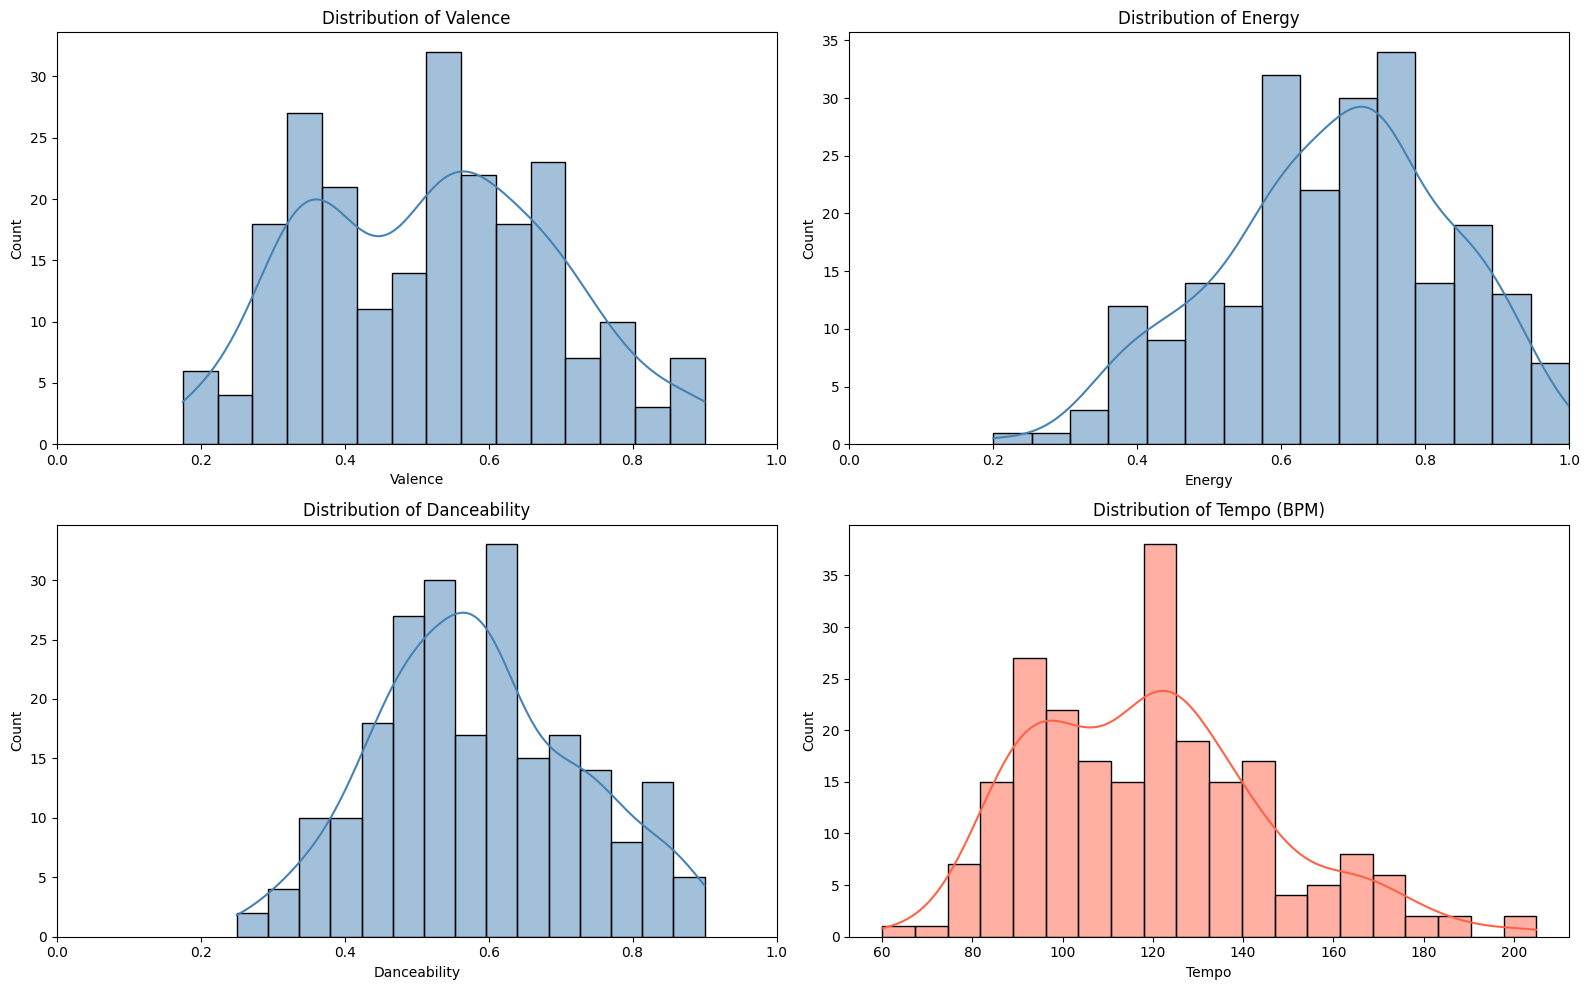

In [48]:
# Features distribution of the filtered records

plt.figure(figsize=(16, 10))

# Plot valence, energy, danceability
for i, feature in enumerate(low_scale_features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df_withfeatures[feature], bins=15, kde=True, color='steelblue')
    plt.title(f'Distribution of {feature.capitalize()}')
    plt.xlabel(feature.capitalize())
    plt.ylabel('Count')
    plt.xlim(0, 1)  # Normalize range

# Plot tempo separately
plt.subplot(2, 2, 4)
sns.histplot(df_withfeatures[high_scale_feature], bins=20, kde=True, color='tomato')
plt.title('Distribution of Tempo (BPM)')
plt.xlabel('Tempo')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [49]:
avg_features = df_withfeatures[['valence', 'energy', 'danceability','tempo']].mean()
avg_features

valence           0.521868
energy            0.672716
danceability      0.585640
tempo           119.230114
dtype: float64

In [50]:
df_withfeatures.to_csv('soundtrack_data_final.csv', index=False, encoding='utf-8')

## Normalization

In [3]:
df_withfeatures = pd.read_csv('soundtrack_data_final.csv')

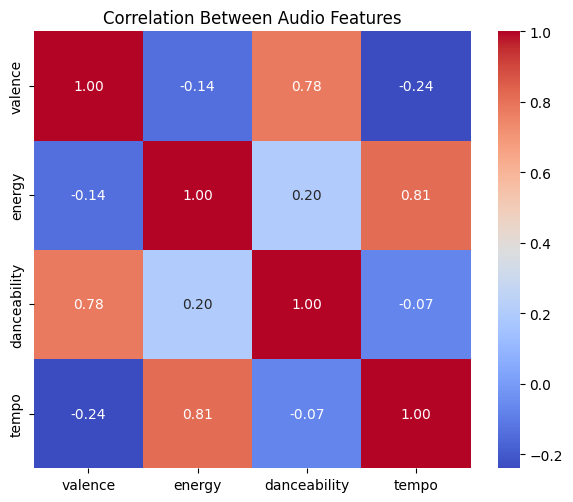

In [51]:
# Use only rows with no missing values
df_corr = df_withfeatures[['valence', 'energy', 'danceability', 'tempo']].dropna()

# Compute correlation matrix
corr_matrix = df_corr.corr()

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Between Audio Features")
plt.tight_layout()
plt.show()


In [5]:
df_withfeatures['track_order'] = df_withfeatures.groupby('movie').cumcount()
df_withfeatures['track_order_norm'] = df_withfeatures.groupby('movie')['track_order'].transform(
    lambda x: x / x.max() if x.max() > 0 else 0
)

In [6]:
df_withfeatures.head()

,track,artist,remixer,movie,imdb_id,genres_a,genres_r,primary_genre,valence,energy,danceability,tempo,track_order,track_order_norm
0,High Adventure,NaN,NaN,SLC Punk,tt0133189,[],[],NaN,NaN,NaN,NaN,NaN,0,0.000000
1,Sex & Violence,The Exploited(as Exploited),NaN,SLC Punk,tt0133189,[],[],NaN,NaN,NaN,NaN,NaN,1,0.024390
2,Too Hot,The Specials,NaN,SLC Punk,tt0133189,"['ska', 'rocksteady', 'ska punk']",[],ska,0.666667,0.716667,0.766667,133.333333,2,0.048780
3,Mirror in the Bathroom,Fifi,NaN,SLC Punk,tt0133189,[],[],NaN,NaN,NaN,NaN,NaN,3,0.073171
4,Champaign Breakfast,John Sbarra,NaN,SLC Punk,tt0133189,"['ragtime', 'exotica']",[],ragtime,0.725000,0.450000,0.650000,100.000000,4,0.097561


In [7]:
features = ['valence', 'energy', 'danceability', 'tempo']
df_pre_norm = df_withfeatures.dropna(subset=features)

In [8]:
df_pre_norm.head()

,track,artist,remixer,movie,imdb_id,genres_a,genres_r,primary_genre,valence,energy,danceability,tempo,track_order,track_order_norm
2,Too Hot,The Specials,NaN,SLC Punk,tt0133189,"['ska', 'rocksteady', 'ska punk']",[],ska,0.666667,0.716667,0.766667,133.333333,2,0.048780
4,Champaign Breakfast,John Sbarra,NaN,SLC Punk,tt0133189,"['ragtime', 'exotica']",[],ragtime,0.725000,0.450000,0.650000,100.000000,4,0.097561
6,1969,The Stooges,NaN,SLC Punk,tt0133189,"['proto-punk', 'punk', 'garage rock']",[],proto-punk,0.350000,0.816667,0.483333,156.666667,6,0.146341
8,I Love Livin' in the City,Fear,NaN,SLC Punk,tt0133189,"['new wave', 'synthpop']",[],new wave,0.650000,0.700000,0.725000,122.500000,8,0.195122
9,No More Bullshit,Camper Van Beethoven,NaN,SLC Punk,tt0133189,"['jangle pop', 'alternative rock']",[],jangle pop,0.575000,0.650000,0.575000,130.000000,9,0.219512


In [9]:
df_norm = normalize_features_by_movie(df_pre_norm, features)

df_norm.head(5)

,track,artist,remixer,movie,imdb_id,genres_a,genres_r,primary_genre,valence,energy,danceability,tempo,track_order,track_order_norm,valence_norm,energy_norm,danceability_norm,tempo_norm
2,Too Hot,The Specials,NaN,SLC Punk,tt0133189,"['ska', 'rocksteady', 'ska punk']",[],ska,0.666667,0.716667,0.766667,133.333333,2,0.048780,0.626667,0.712644,0.814815,0.575163
4,Champaign Breakfast,John Sbarra,NaN,SLC Punk,tt0133189,"['ragtime', 'exotica']",[],ragtime,0.725000,0.450000,0.650000,100.000000,4,0.097561,0.720000,0.344828,0.555556,0.313725
6,1969,The Stooges,NaN,SLC Punk,tt0133189,"['proto-punk', 'punk', 'garage rock']",[],proto-punk,0.350000,0.816667,0.483333,156.666667,6,0.146341,0.120000,0.850575,0.185185,0.758170
8,I Love Livin' in the City,Fear,NaN,SLC Punk,tt0133189,"['new wave', 'synthpop']",[],new wave,0.650000,0.700000,0.725000,122.500000,8,0.195122,0.600000,0.689655,0.722222,0.490196
9,No More Bullshit,Camper Van Beethoven,NaN,SLC Punk,tt0133189,"['jangle pop', 'alternative rock']",[],jangle pop,0.575000,0.650000,0.575000,130.000000,9,0.219512,0.480000,0.620690,0.388889,0.549020


In [57]:
df_norm[df_norm['movie'] == 'SLC Punk'][['track_order', 'valence_norm',  'energy_norm', 'danceability_norm', 'tempo_norm']]

,track_order,valence_norm,energy_norm,danceability_norm,tempo_norm
2,2,0.626667,0.712644,0.814815,0.575163
4,4,0.720000,0.344828,0.555556,0.313725
6,6,0.120000,0.850575,0.185185,0.758170
8,8,0.600000,0.689655,0.722222,0.490196
9,9,0.480000,0.620690,0.388889,0.549020
12,12,0.120000,0.850575,0.185185,0.758170
13,13,0.080000,0.862069,0.166667,0.823529
14,14,0.360000,0.879310,0.527778,0.862745
17,17,0.080000,0.862069,0.166667,0.823529
19,19,0.626667,0.712644,0.814815,0.575163


## Interpolation

In [10]:
movies = df_withfeatures['movie'].unique()

valence_curves = {m: resample_mood_arc(df_norm, m, 'valence_norm') for m in movies}
energy_curves = {m: resample_mood_arc(df_norm, m, 'energy_norm') for m in movies}
danceability_curves = {m: resample_mood_arc(df_norm, m, 'danceability_norm') for m in movies}
tempo_curves = {m: resample_mood_arc(df_norm, m, 'tempo_norm') for m in movies}


# Combine valence and energy into a feature matrix
features = []
labels = []
for m in movies:
    combined = np.concatenate([valence_curves[m], energy_curves[m], danceability_curves[m], tempo_curves[m]])
    features.append(combined)
    labels.append(m)

features_df = pd.DataFrame(features, index=labels)

In [11]:
features_df.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
SLC Punk,0.626667,0.553333,0.466667,0.266667,0.414074,0.520000,0.591111,0.013333,0.555556,0.060000,...,0.575163,0.437182,0.556766,0.849673,0.671750,0.400871,0.043573,0.973130,0.484749,0.901961
SubUrbia (Linklater),0.309524,0.325397,0.793651,0.619048,0.386243,0.047619,0.071429,0.269841,0.724868,0.142857,...,1.000000,0.321970,0.151515,0.272727,0.367172,0.487879,0.459091,0.116667,0.063131,0.230114
Suburbia (Penelope Spheeris),1.000000,1.000000,1.000000,1.000000,0.777778,0.222222,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.222222,0.777778,1.000000,1.000000,1.000000,1.000000
Smithereens,0.166667,0.166667,0.351852,0.944444,0.759259,0.574074,0.388889,0.203704,0.018519,0.750000,...,0.653333,0.653333,0.685926,0.755556,0.607407,0.459259,0.311111,0.162963,0.014815,1.000000
Ghost World,0.333333,0.333333,0.573192,0.089947,0.471429,0.619048,1.000000,0.735450,0.743386,0.333333,...,0.724138,0.724138,0.358238,0.988506,0.259195,0.775862,0.344828,0.696839,0.545977,0.000000


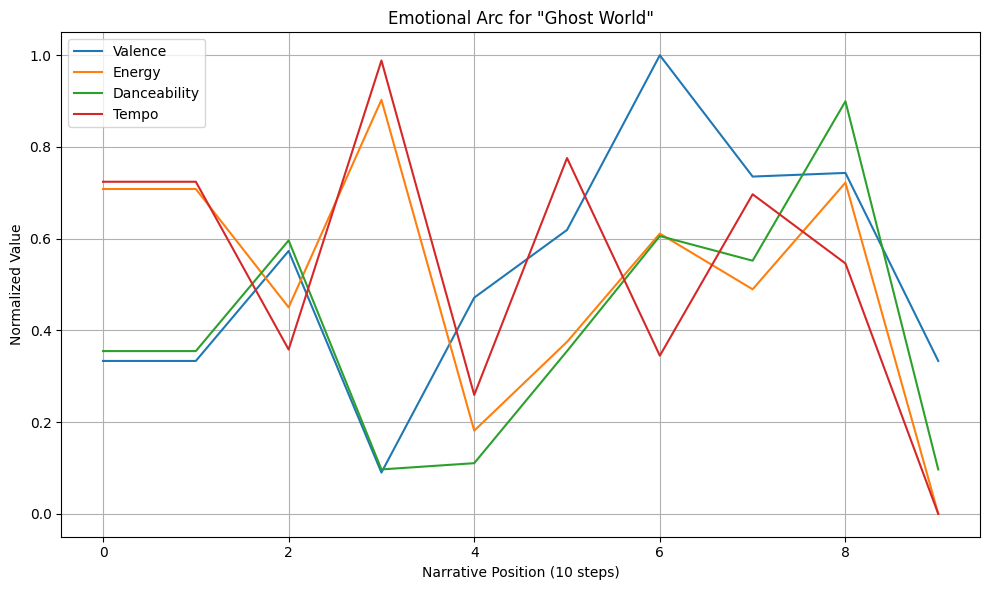

In [23]:
movie = 'Ghost World' 

plt.figure(figsize=(10, 6))

plt.plot(valence_curves[movie], label='Valence')
plt.plot(energy_curves[movie], label='Energy')
plt.plot(danceability_curves[movie], label='Danceability')
plt.plot(tempo_curves[movie], label='Tempo')

plt.title(f'Emotional Arc for "{movie}"')
plt.xlabel('Narrative Position (10 steps)')
plt.ylabel('Normalized Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



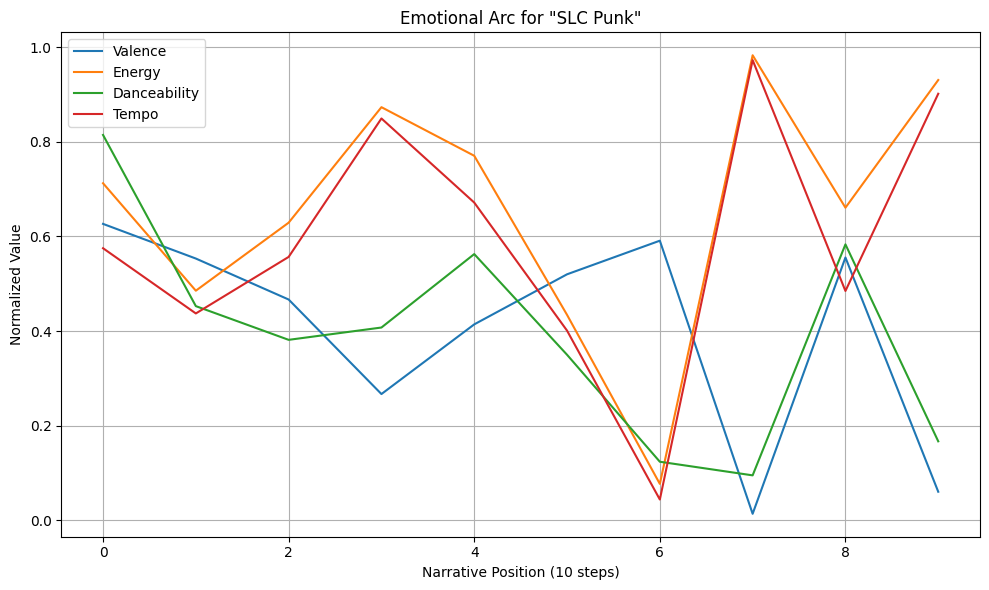

In [24]:
movie = 'SLC Punk'  

plt.figure(figsize=(10, 6))

plt.plot(valence_curves[movie], label='Valence')
plt.plot(energy_curves[movie], label='Energy')
plt.plot(danceability_curves[movie], label='Danceability')
plt.plot(tempo_curves[movie], label='Tempo')

plt.title(f'Emotional Arc for "{movie}"')
plt.xlabel('Narrative Position (10 steps)')
plt.ylabel('Normalized Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


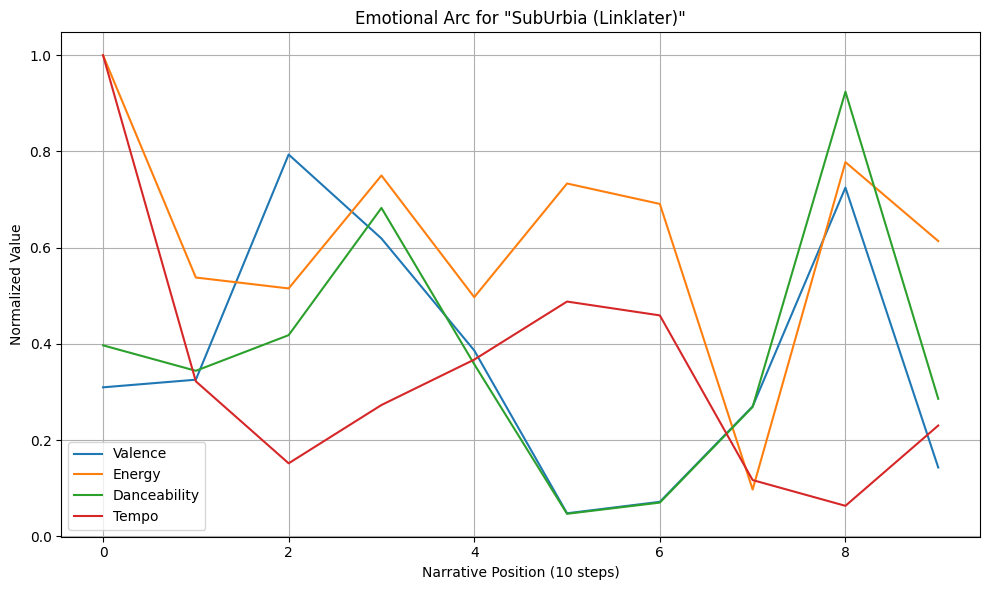

In [25]:
movie = 'SubUrbia (Linklater)'  

plt.figure(figsize=(10, 6))

plt.plot(valence_curves[movie], label='Valence')
plt.plot(energy_curves[movie], label='Energy')
plt.plot(danceability_curves[movie], label='Danceability')
plt.plot(tempo_curves[movie], label='Tempo')

plt.title(f'Emotional Arc for "{movie}"')
plt.xlabel('Narrative Position (10 steps)')
plt.ylabel('Normalized Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## PCA

In [ ]:
# 1. Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_df)

# 2. PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


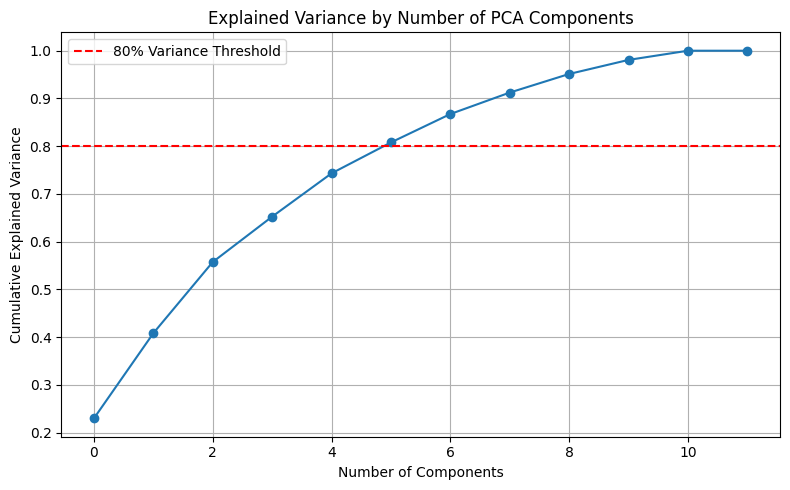

In [ ]:

# 1. Fit PCA without limiting components
pca_full = PCA()
pca_full.fit(X_scaled)

# 2. Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of PCA Components')
plt.grid(True)
plt.axhline(y=0.8, color='r', linestyle='--', label='80% Variance Threshold')
plt.legend()
plt.tight_layout()
plt.show()


In [12]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_df)

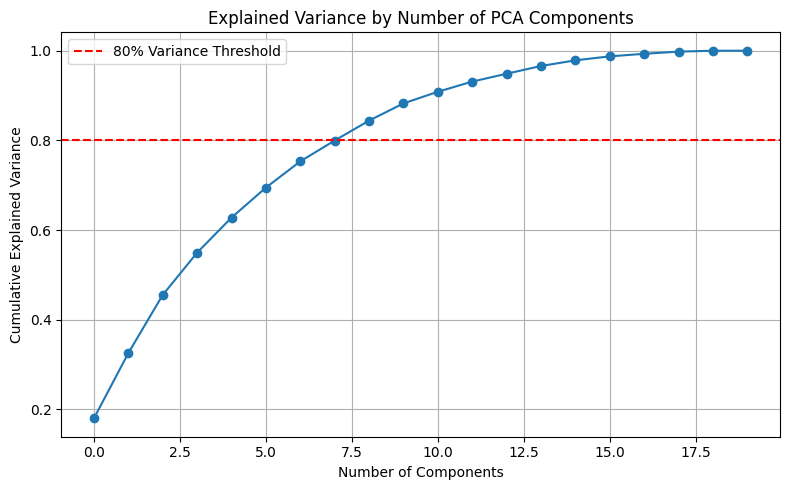

In [13]:
pca_full = PCA()
pca_full.fit(X_scaled)

# 2. Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of PCA Components')
plt.grid(True)
plt.axhline(y=0.8, color='r', linestyle='--', label='80% Variance Threshold')
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
# 2. PCA
pca = PCA(n_components=7)
X_pca = pca.fit_transform(X_scaled)

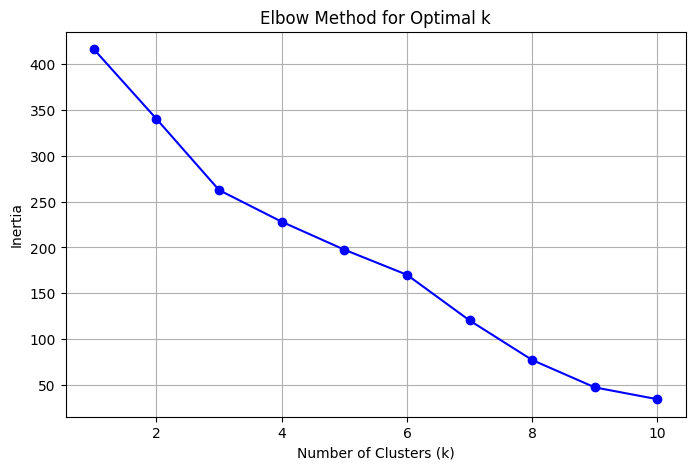

In [ ]:
# Use your standardized feature matrix
inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)  # Sum of squared distances to cluster centers

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()


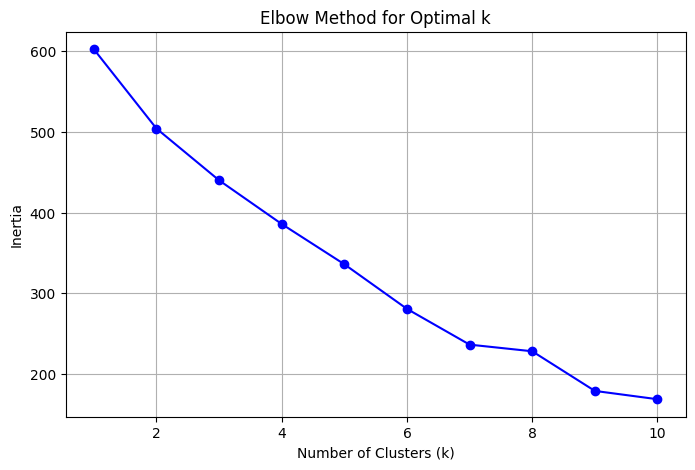

In [ ]:
# Use your standardized feature matrix
inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=33)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)  # Sum of squared distances to cluster centers

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()


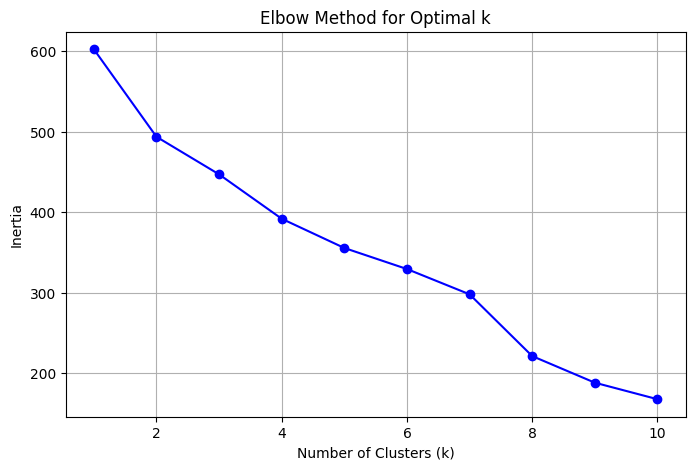

In [22]:
# Use your standardized feature matrix
inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=33)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)  # Sum of squared distances to cluster centers

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

In [15]:
# 3. KMeans
kmeans = KMeans(n_clusters=6, random_state=33)
labels = kmeans.fit_predict(X_pca)

# 4. Add cluster labels back
features_df['cluster'] = labels

In [16]:
kmeans.cluster_centers_

array([[-2.96328091, -0.90364759,  0.41284189, -0.92830871,  1.55127549,
         0.96572434, -1.05068841],
       [ 0.96107209,  0.3983574 , -1.38301147, -0.62546007,  0.00960496,
         0.32460592,  0.18063588],
       [ 2.72268433,  0.98732469,  3.91735872,  2.04384137, -0.95551016,
         1.47950631, -0.11451912],
       [-1.93845439,  6.50680521,  0.29386105, -1.92227128, -0.85527881,
        -1.15503943,  0.93289854],
       [-0.30821668, -2.20627028, -0.50573536,  2.05677817,  0.18066593,
        -1.01597765,  1.00810424],
       [ 1.42578571,  0.58485755,  0.96203782, -1.1505344 , -2.11435064,
        -1.9376007 , -0.89898738]])

In [17]:
for c in sorted(features_df['cluster'].unique()):
    cluster_movies = features_df[features_df['cluster'] == c].index
    print(f"\n🎥 Cluster {c}: {list(cluster_movies)}")


🎥 Cluster 0: ['Ghost World', 'Permanent Record', 'The Doom Generation', 'Slacker']

🎥 Cluster 1: ['SLC Punk', 'Suburbia (Penelope Spheeris)', 'Smithereens', 'Times Square', 'Kids', 'We Are the Best!', 'Mid90s']

🎥 Cluster 2: ['Ladies and Gentlemen, The Fabulous Stains', 'Wild Tigers I Have Known']

🎥 Cluster 3: ['My Own Private Idaho']

🎥 Cluster 4: ['SubUrbia (Linklater)', 'Out of the Blue', 'River’s Edge', 'Paranoid Park (Gus Van Sant)']

🎥 Cluster 5: ['Gummo', 'Nowhere']


In [18]:
cluster_names = {
    0: "Detached Nihilism",
    1: "Rebel without Resolution",
    2: "Feminist & Queer Assertion",
    3: "Lonely Drifter",
    4: "Haunting Realism",
    5: "Chaotic Surrealism"
}

In [19]:
features_df['cluster_name'] = features_df['cluster'].map(cluster_names)

{'SLC Punk': 'Rebel without Resolution', 'SubUrbia (Linklater)': 'Haunting Realism', 'Suburbia (Penelope Spheeris)': 'Rebel without Resolution', 'Smithereens': 'Rebel without Resolution', 'Ghost World': 'Detached Nihilism', 'Out of the Blue': 'Haunting Realism', 'Ladies and Gentlemen, The Fabulous Stains': 'Feminist & Queer Assertion', 'Times Square': 'Rebel without Resolution', 'River’s Edge': 'Haunting Realism', 'Permanent Record': 'Detached Nihilism', 'Gummo': 'Chaotic Surrealism', 'Kids': 'Rebel without Resolution', 'The Doom Generation': 'Detached Nihilism', 'My Own Private Idaho': 'Lonely Drifter', 'We Are the Best!': 'Rebel without Resolution', 'Mid90s': 'Rebel without Resolution', 'Paranoid Park (Gus Van Sant)': 'Haunting Realism', 'Wild Tigers I Have Known': 'Feminist & Queer Assertion', 'Slacker': 'Detached Nihilism', 'Nowhere': 'Chaotic Surrealism'}
Chaotic Surrealism


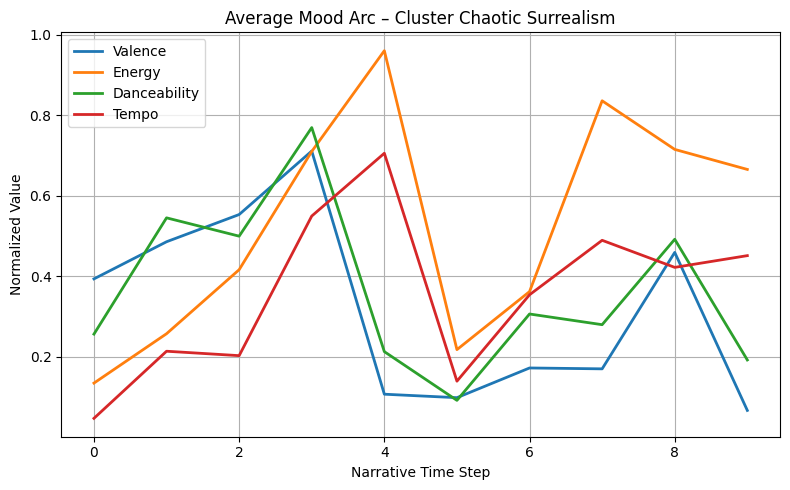

Detached Nihilism


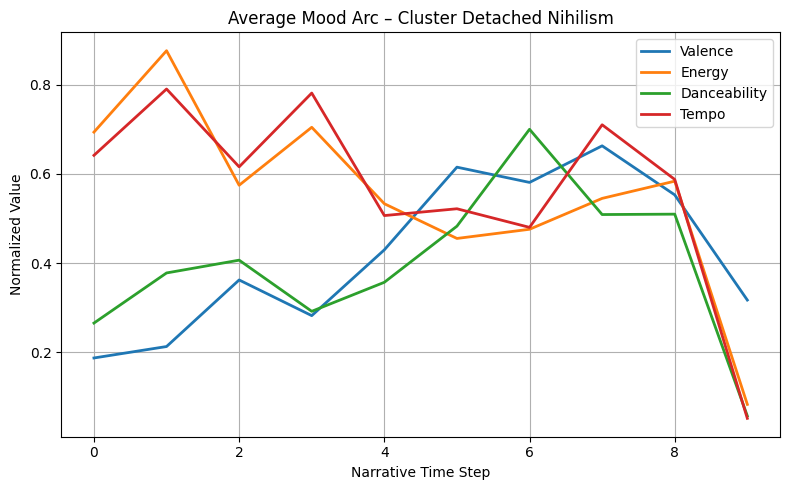

Feminist & Queer Assertion


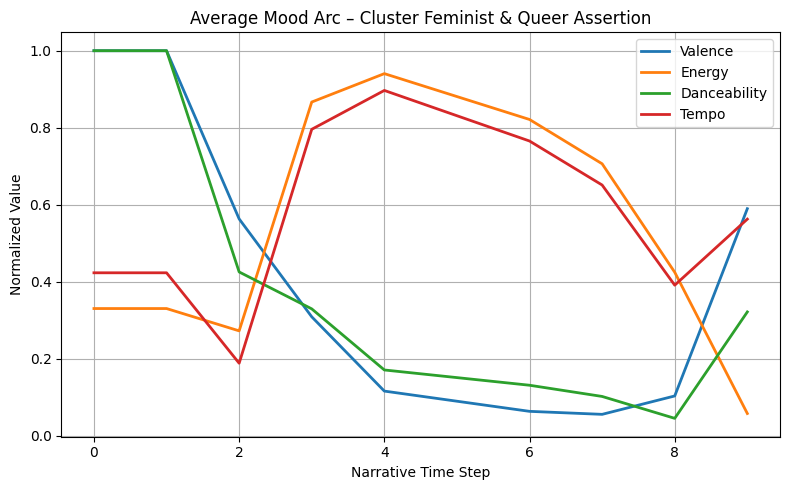

Haunting Realism


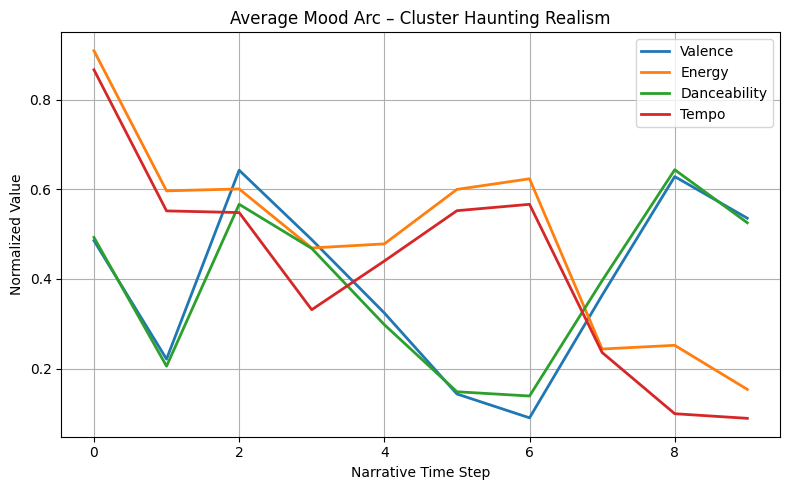

Lonely Drifter


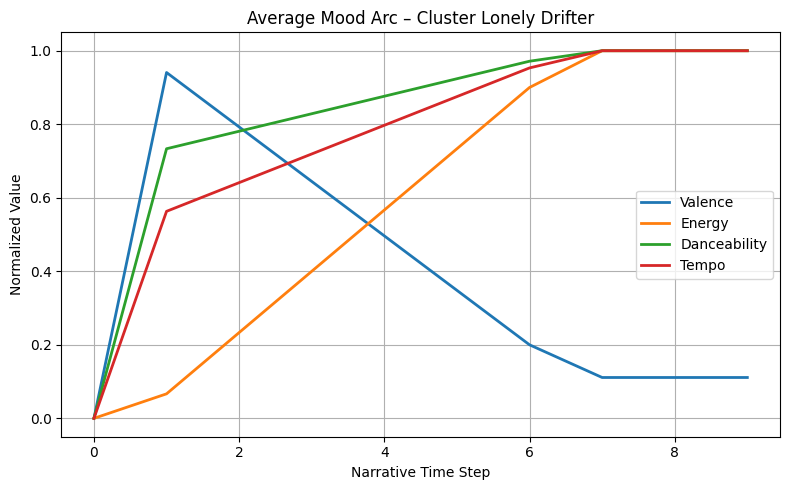

Rebel without Resolution


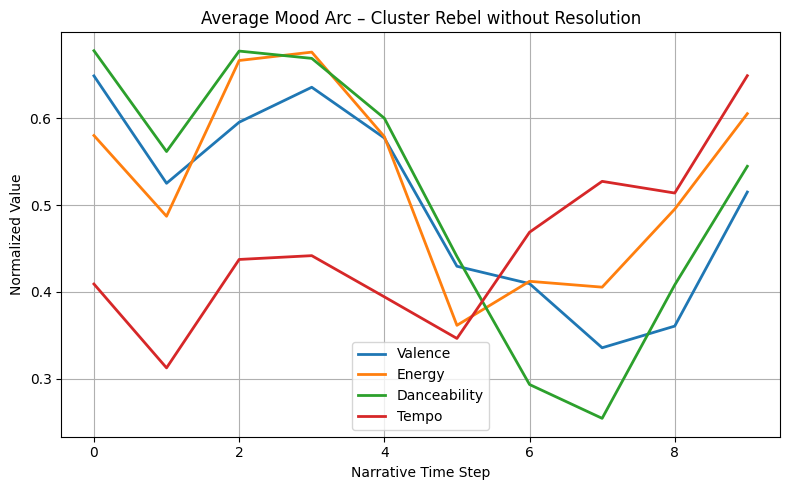

In [ ]:
# Create a mapping from movie title to its assigned cluster
# If 'movie' is actually the index, just use:
cluster_map = features_df['cluster_name'].to_dict()
print(cluster_map)


# Build a DataFrame of mood features by movie
df_plot = pd.DataFrame({
    "movie": list(valence_curves.keys()),
    "cluster_name": [cluster_map[m] for m in valence_curves.keys()],
    "valence": list(valence_curves.values()),
    "energy": list(energy_curves.values()),
    "danceability": list(danceability_curves.values()),
    "tempo": list(tempo_curves.values()),
})

# For each cluster, compute average arc per feature
for cluster_name in sorted(df_plot['cluster_name'].unique()):
    print(cluster_name)
    subset = df_plot[df_plot['cluster_name'] == cluster_name]
    
    mean_valence = np.mean(np.stack(subset['valence']), axis=0)
    mean_energy = np.mean(np.stack(subset['energy']), axis=0)
    mean_dance = np.mean(np.stack(subset['danceability']), axis=0)
    mean_tempo = np.mean(np.stack(subset['tempo']), axis=0)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(mean_valence, label='Valence', linewidth=2)
    plt.plot(mean_energy, label='Energy', linewidth=2)
    plt.plot(mean_dance, label='Danceability', linewidth=2)
    plt.plot(mean_tempo, label='Tempo', linewidth=2)
    
    plt.title(f'Average Mood Arc – Cluster {cluster_name}')
    plt.xlabel('Narrative Time Step')
    plt.ylabel('Normalized Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


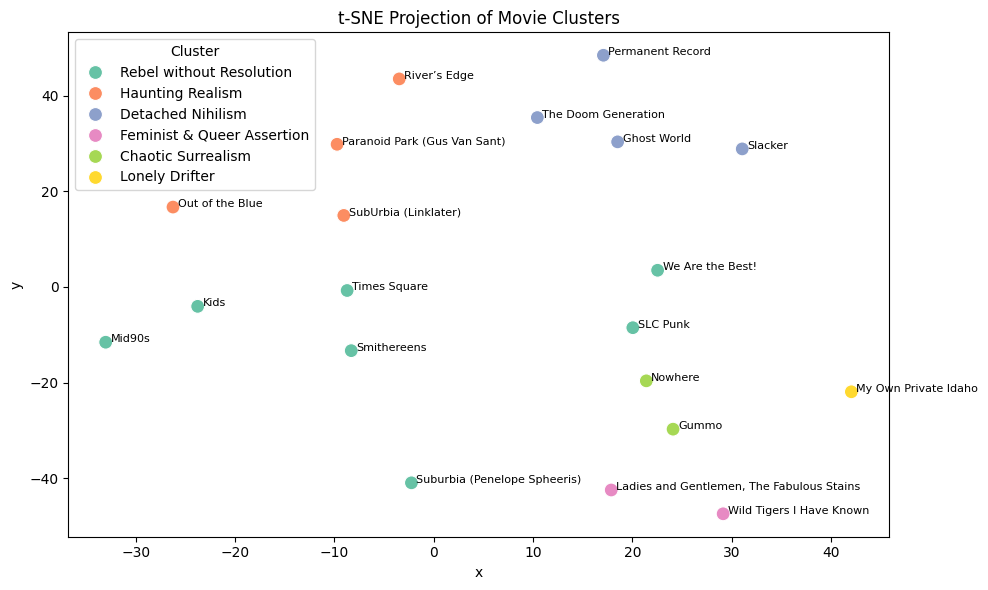

In [ ]:
tsne = TSNE(n_components=2, perplexity=5, random_state=33)
X_tsne = tsne.fit_transform(features_df.drop(['cluster','cluster_name'], axis=1))

df_tsne = pd.DataFrame(X_tsne, columns=['x', 'y'])
df_tsne['cluster_name'] = features_df['cluster_name'].values
df_tsne['movie'] = features_df.index

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_tsne, x='x', y='y', hue='cluster_name', palette='Set2', s=100)

# Annotate movie names
for _, row in df_tsne.iterrows():
    plt.text(row['x']+0.5, row['y'], row['movie'], fontsize=8)

plt.title("t-SNE Projection of Movie Clusters")
plt.legend(title='Cluster', loc='upper left')
plt.tight_layout()
plt.show()
